In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv("../dataset.csv")  

In [4]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


In [5]:
straight_activities = ["Standing", "Walking", "Jogging"]

df["leg_straight"] = df["activity"].apply(lambda x: 1 if x in straight_activities else 0)

print(df[["activity", "leg_straight"]].head(10))

  activity  leg_straight
0  Walking             1
1  Walking             1
2  Walking             1
3  Walking             1
4  Walking             1
5  Walking             1
6  Walking             1
7  Walking             1
8  Walking             1
9  Walking             1


In [6]:
window_size = 200  # number of samples per window (~2–4 seconds depending on frequency)
step_size = 100    # 50% overlap

X, y, activities = [], [], []

for _, df_act in df.groupby("activity"):
    signals = df_act[['x-axis','y-axis','z-axis']].values
    labels = df_act['leg_straight'].values
    acts = df_act['activity'].values
    
    for start in range(0, len(signals) - window_size, step_size):
        end = start + window_size
        X.append(signals[start:end])
        y.append(labels[start])
        activities.append(acts[start])   # <--- original activity

X = np.array(X)
y = np.array(y)
activities = np.array(activities)

print("X shape:", X.shape)  # (num_windows, window_size, 3)
print("y shape:", y.shape)
print("Activities shape:", activities.shape)


X shape: (10726, 200, 3)
y shape: (10726,)
Activities shape: (10726,)


In [7]:
scaler = StandardScaler()
X_reshaped = X.reshape(-1, 3)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [9]:
X_train, X_test, y_train, y_test, act_train, act_test = train_test_split(
    X_scaled, y, activities,
    test_size=0.3, random_state=42, stratify=y
)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 3)),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\tudor\miniconda3\envs\mod9\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 198, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 196, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,153 (3.15 MB)

 Trainable params: 824,769 (3.15 MB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64
)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.8551 - loss: 0.3716 - val_accuracy: 0.7732 - val_loss: 1.0086
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.8551 - loss: 0.3716 - val_accuracy: 0.7732 - val_loss: 1.0086
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9313 - loss: 0.1718 - val_accuracy: 0.7502 - val_loss: 1.3149
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.9313 - loss: 0.1718 - val_accuracy: 0.7502 - val_loss: 1.3149
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9594 - loss: 0.1113 - val_accuracy: 0.8219 - val_loss: 0.5496
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9594 - loss: 0.1113 - val_accuracy: 0.8219 - val_loss: 0.5496
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9716 - loss: 0.0777 - val_accuracy: 0.9503 - val_loss: 0.1621
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9716 - loss: 0.0777 - val_accu

In [12]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9891 - loss: 0.0479
Test Accuracy: 0.9891
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9891 - loss: 0.0479
Test Accuracy: 0.9891


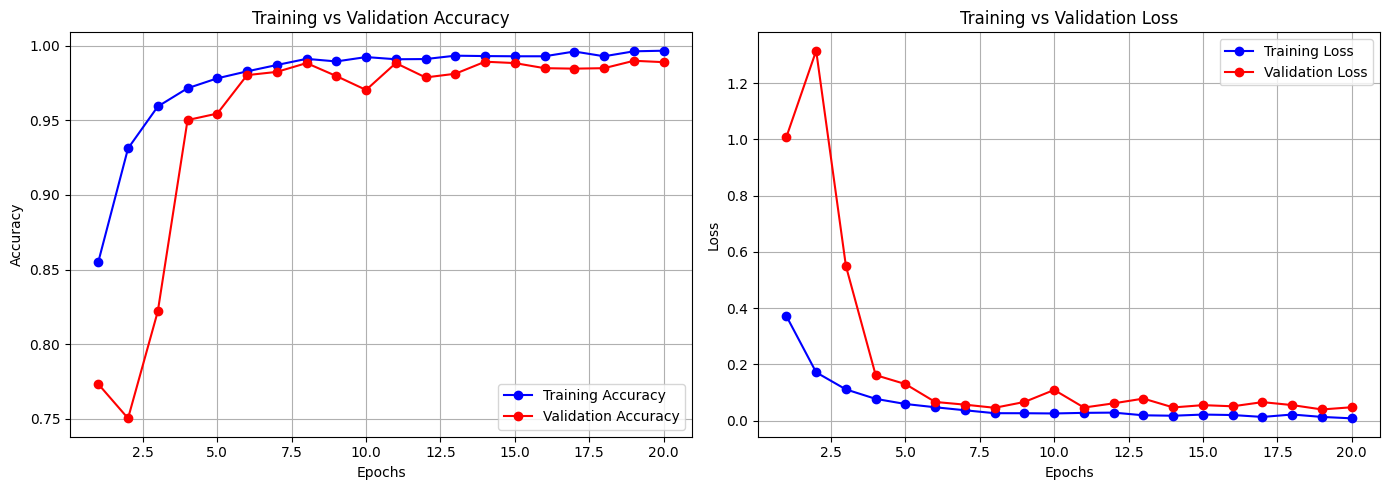

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(14,5))

# acc
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
ROC AUC (roc_auc_score): 0.9980
ROC AUC (trapezoidal auc): 0.9980


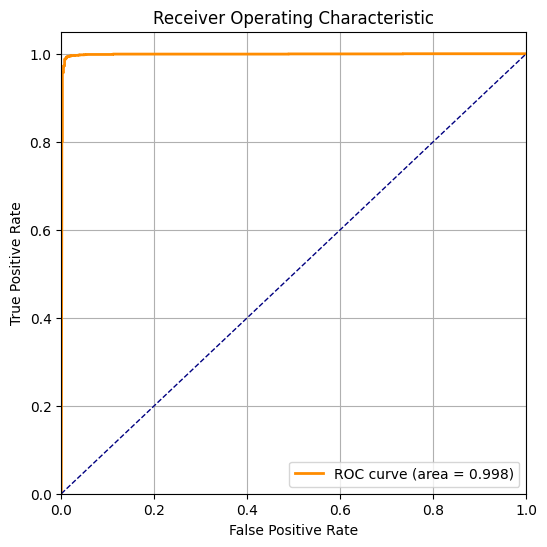

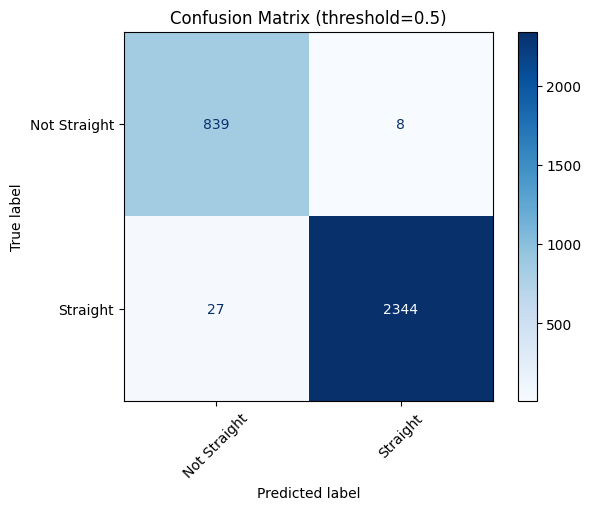

In [ ]:
y_proba = model.predict(X_test).ravel()

roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)
print(f"ROC AUC (roc_auc_score): {roc_auc:.4f}")
print(f"ROC AUC (trapezoidal auc): {roc_auc_val:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

y_pred = (y_proba > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Straight", "Straight"])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()


In [ ]:
try:
    y_proba
except NameError:
    y_proba = model.predict(X_test).ravel()

y_pred = (y_proba > 0.5).astype("int32").ravel()


In [16]:
results = pd.DataFrame({
    "Activity": act_test,
    "True_Label": y_test,
    "Predicted_Label": y_pred
})

activity_analysis = results.groupby("Activity")[["True_Label", "Predicted_Label"]].agg(
    True_Straight=("True_Label", "sum"),
    True_Total=("True_Label", "count"),
    Pred_Straight=("Predicted_Label", "sum")
)

activity_analysis["Pred_Straight_Ratio"] = activity_analysis["Pred_Straight"] / activity_analysis["True_Total"]

print(activity_analysis)


            True_Straight  True_Total  Pred_Straight  Pred_Straight_Ratio
Activity                                                                 
Downstairs              0         307              2             0.006515
Jogging               953         953            933             0.979014
Sitting                 0         178              1             0.005618
Standing              164         164            164             1.000000
Upstairs                0         362              5             0.013812
Walking              1254        1254           1247             0.994418
